In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Inputs

In [2]:
# data
n = 1000
noise = .2
test_size = .2
val_size = .3

# model
# modelName = 'Basic'
# modelName = 'FCNet'
modelName = 'DeepNet'
# modelName = 'DeepNet_degenerateLast'

# seed
seed = 11 # 10 does not work for DeepNet_degenerateLast
def set_seed(seed = 8):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(seed)

## Data

In [3]:
# synthetic data
X, y = make_moons(n_samples=n, shuffle=True, noise=noise, random_state=seed)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=test_size,
                                                          random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=val_size,
                                                  random_state=seed)

# grid (for plots)
_x, _y = np.linspace(-3, 3, 50), np.linspace(-2, 2, 50)
_xx, _yy = np.meshgrid(_x, _y)
_xx, _yy = _xx.flatten(), _yy.flatten()
grid = torch.tensor(np.vstack((_xx, _yy)).transpose(), dtype=torch.float).view(-1, 2)

Text(0.5, 1.0, 'toy data')

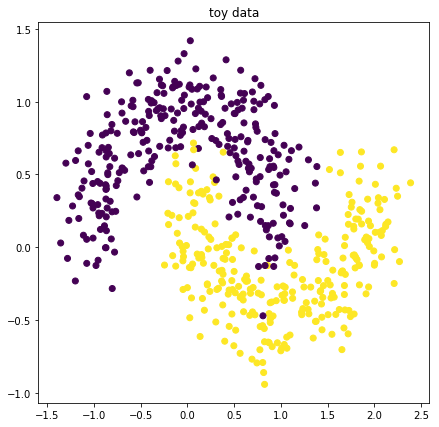

In [4]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, marker = 'o')
ax.set_title('toy data')

## Experiments

In [5]:
# define model
class BasicNet(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(BasicNet.inputDim, BasicNet.outputDim) # initializes at random
        
    def featurize(self, x):
        return x
    
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [6]:
# define model
class FCNet(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self, h):
        """ h: number of units in hidden layer """
        super().__init__()
        
        self.fc1 = nn.Linear(FCNet.inputDim, h) # initializes at random
        self.fc2 = nn.Linear(h, FCNet.outputDim) # initializes at random

    def featurize(self, x):
        x = torch.relu(self.fc1(x))        
        return x
    
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [7]:
# define model
class DeepNet(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self, h, degenerateLast=False):
        """
        h: number of units per hidden layer
        """
        super().__init__()
        
        self.fc1 = nn.Linear(DeepNet.inputDim, h) # initializes at random
        self.fc2 = nn.Linear(h, h) # initializes at random
        self.fc3 = nn.Linear(h, h) # initializes at random
        if not degenerateLast:
            self.fc4 = nn.Linear(h, h) # initializes at random
            self.fc5 = nn.Linear(h, DeepNet.outputDim) # initializes at random
        else:
            self.fc4 = nn.Linear(h, 1) # initializes at random
            self.fc5 = nn.Linear(1, DeepNet.outputDim) # initializes at random
            
    def featurize(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x
        
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc5(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [8]:
# instanciate model and setup
if modelName == 'BasicNet':
    model = BasicNet(); nbEpochs = 100; lr=0.01 # use RMSProp
elif modelName == 'FCNet':
    model = FCNet(20); nbEpochs = 100; lr=0.01 # use RMSProp
elif modelName == 'DeepNet':
    model = DeepNet(100); nbEpochs = 500; lr=0.001 # use RMSProp
elif modelName == 'DeepNet_degenerateLast':
    model = DeepNet(100, degenerateLast=True); nbEpochs = 500; lr=0.001 # use RMSProp
else:
    raise ValueError('unkown modelName: {}'.format(modelName))

lossfn = nn.BCELoss() # BinaryCrossEntropy
# optimizer = optim.SGD(model.parameters(), lr=0.1) # using a better optimizer DOES make a difference
optimizer = optim.RMSprop(model.parameters(),
                          lr=lr,
                          alpha=0.99,
                          eps=1e-08,
                          weight_decay=0,
                          momentum=0.9,
                          centered=False)
# optimizer = optim.Adam(model.parameters(),
#                        lr=0.01,
#                        betas=(0.9, 0.999),
#                        eps=1e-08,
#                        weight_decay=0,
#                        amsgrad=False)
for p in model.parameters():
    print(p.size())

torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


[1] error: 0.6977741718292236
[11] error: 0.4255739152431488
[21] error: 0.282586008310318
[31] error: 0.18078617751598358
[41] error: 0.12281646579504013
[51] error: 0.07581354677677155
[61] error: 0.05784139037132263
[71] error: 0.051051460206508636
[81] error: 0.046114277094602585
[91] error: 0.0428101122379303
[101] error: 0.03950789198279381
[111] error: 0.036417406052351
[121] error: 0.03353964909911156
[131] error: 0.03145717456936836
[141] error: 0.030383381992578506
[151] error: 0.030210934579372406
[161] error: 0.027347443625330925
[171] error: 0.02675882913172245
[181] error: 0.02481837011873722
[191] error: 0.02587059885263443
[201] error: 0.02448045089840889
[211] error: 0.024630064144730568
[221] error: 0.020536137744784355
[231] error: 0.01852446235716343
[241] error: 0.017940925434231758
[251] error: 0.051431480795145035
[261] error: 0.026537230238318443
[271] error: 0.02072403021156788
[281] error: 0.019445080310106277
[291] error: 0.017451811581850052
[301] error: 0.0

Text(0.5, 1.0, 'train loss')

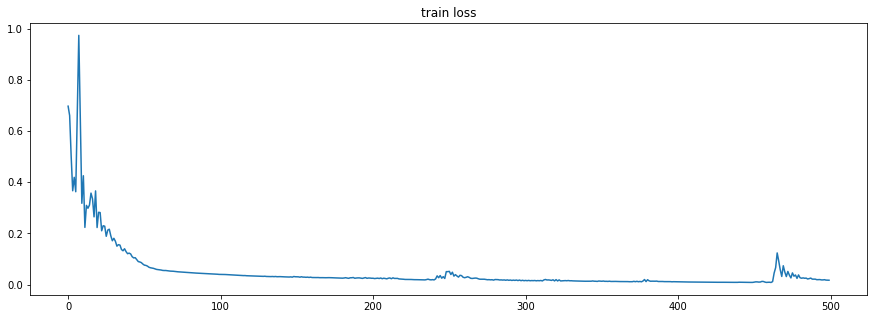

In [9]:
# train model
_X = torch.tensor(X_train, dtype=torch.float)
_y = torch.tensor(y_train, dtype=torch.float).view(-1, 1) # reshape with one column
_aloss = []

for epoch in range(nbEpochs):  # loop over the dataset multiple times
  
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # no minibatch here: take whole dataset
    fX = model(_X)
    loss = lossfn(fX, _y); _aloss.append(loss)
    loss.backward()
    optimizer.step()
        
    # print statistics
    if epoch % 10 == 0:
        print('[{}] error: {}'.format(epoch + 1, loss))

fX = model(_X)
loss = lossfn(fX, _y)
print('[last] error: {}'.format(loss))

print('Finished Training')

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(_aloss)
ax.set_title('train loss')

Text(0.5, 1.0, 'prediction')

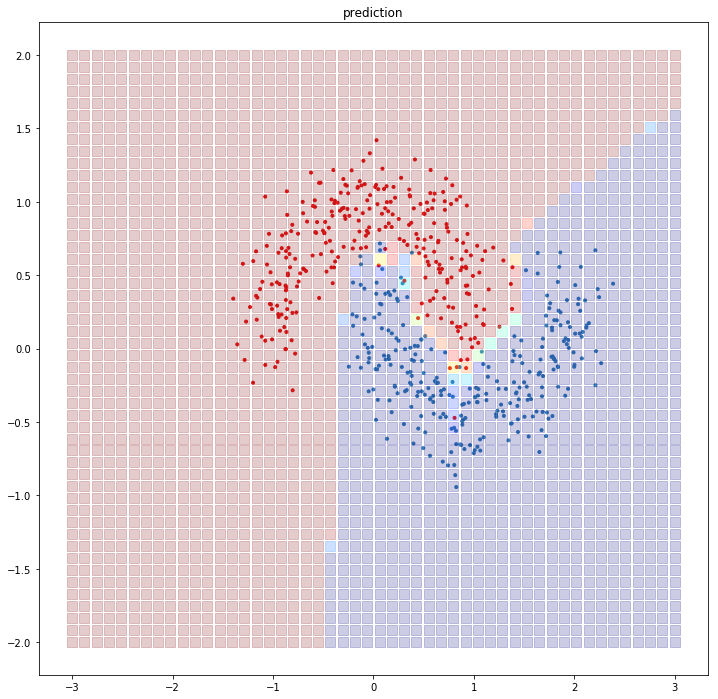

In [10]:
# _gridHat = [int(x) for x in model.predict(grid).detach().numpy().flatten()]
_gridHatProb = model(grid).detach().numpy().flatten()

f = plt.figure(figsize=(12,12))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=cm.Set1(y_train), marker = '.')
# ax.scatter(grid[:,0], grid[:,1], c=cm.Set1(_gridHat), s=100, marker = 's', alpha=.2)
ax.scatter(grid[:,0], grid[:,1], c=cm.jet(1-_gridHatProb), s=100, marker = 's', alpha=.2)
ax.set_title('prediction')

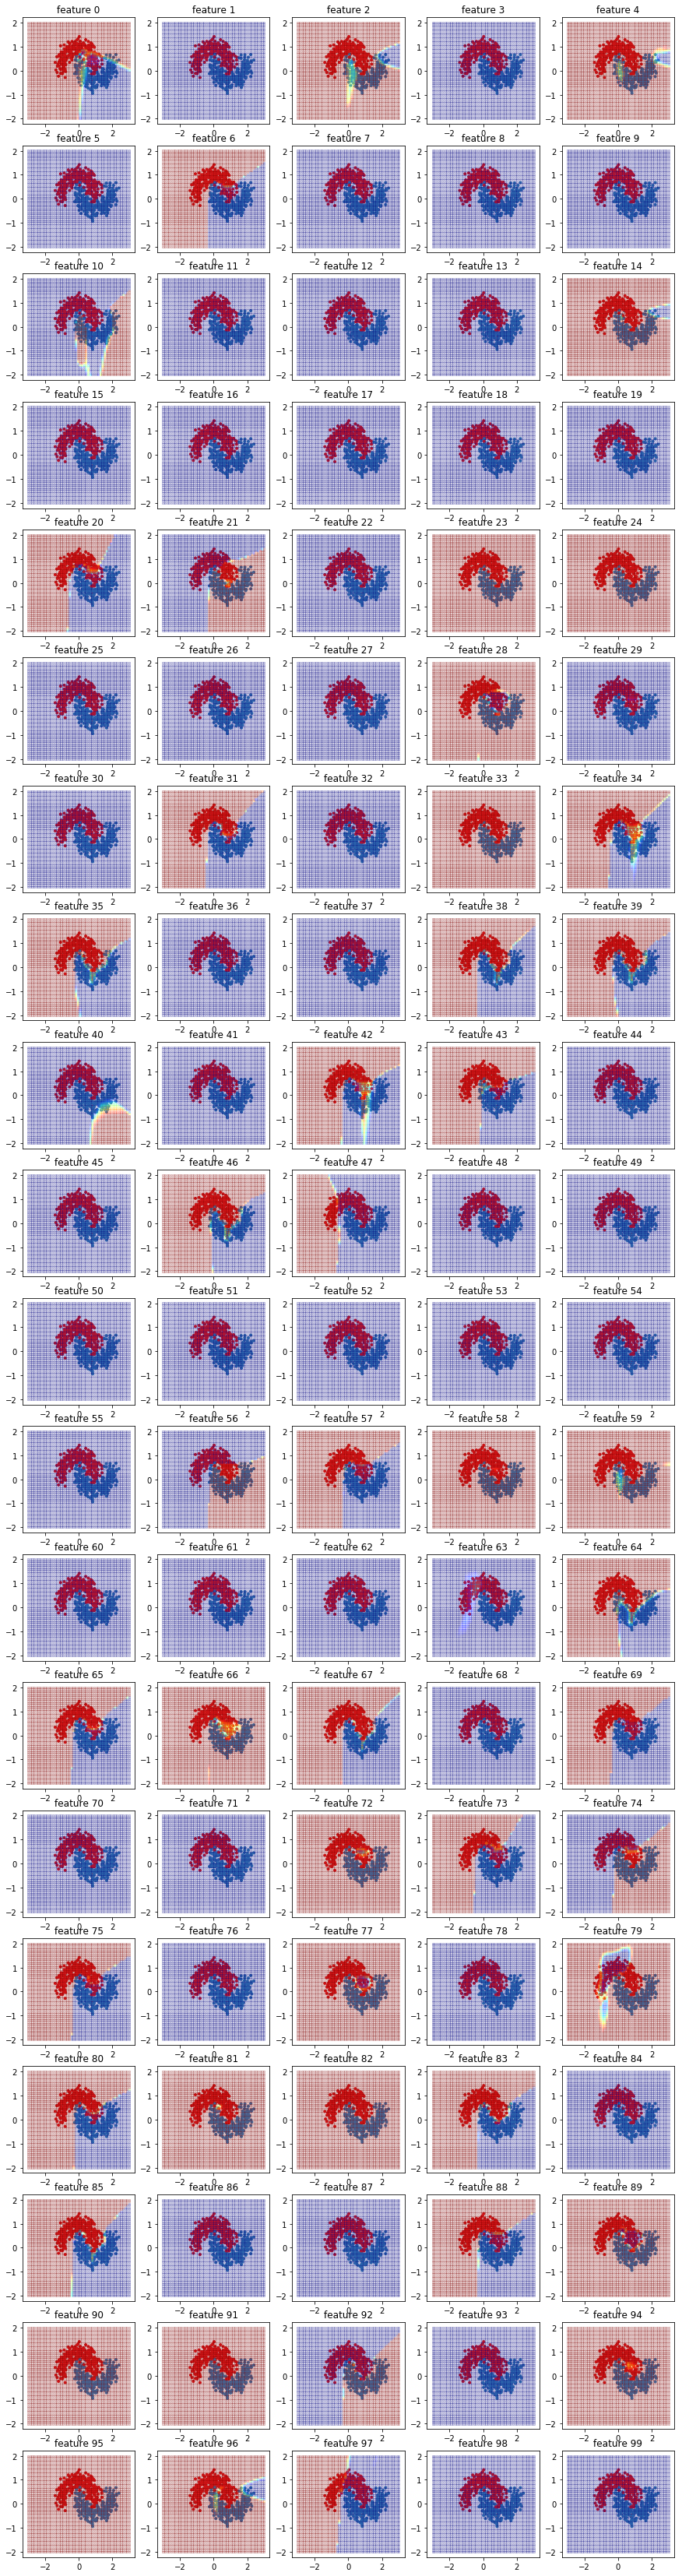

In [11]:
_gridHatFeat = model.featurize(grid).detach().numpy()
_gridHatFeat

K = _gridHatFeat.shape[1]
nc = 5
nr = int(np.ceil(K/nc))

f = plt.figure(figsize=(3*nc,3*nr))
for k in range(K):
    tmp = _gridHatFeat[:,k]
#     tmp = tmp/np.max(tmp) if np.max(tmp)>0 else 0.*tmp
    
    ax = f.add_subplot(nr,nc,1+k)
    ax.scatter(X_train[:,0], X_train[:,1], c=cm.Set1(y_train), marker = '.')
    ax.scatter(grid[:,0], grid[:,1], c=cm.jet(tmp), s=5, marker = 's', alpha=.2)
    ax.set_title('feature {}'.format(k))